In [1]:
import matplotlib.pyplot as plt
from astropy.table import Table, join  
import numpy as np
import collections
import numpy.ma as ma 
import brewer2mpl
from scipy.interpolate import interp1d 
import pandas as pd 

%matplotlib inline

In [59]:
dr7dat = Table.read('/data/sdss/DR7/dr7qso.fit') 
print len(dr7dat[dr7dat['IMAG'] < 19.1])

63855


In [72]:
# Main DR7Q
dr7dat = Table.read('/data/sdss/DR7/dr7qso.fit')

# Shen catalog
shendat = Table.read('/data/lc585/SDSS/dr7_bh_Nov19_2013.fits')

dr7dat['UMAG_DERED_SHEN'] = shendat['UGRIZ_DERED'][:,0]
dr7dat['GMAG_DERED_SHEN'] = shendat['UGRIZ_DERED'][:,1]
dr7dat['RMAG_DERED_SHEN'] = shendat['UGRIZ_DERED'][:,2]
dr7dat['IMAG_DERED_SHEN'] = shendat['UGRIZ_DERED'][:,3]
dr7dat['ZMAG_DERED_SHEN'] = shendat['UGRIZ_DERED'][:,4]
dr7dat['LOGLBOL'] = shendat['LOGLBOL']

# Calculate extinction
with open('/home/lc585/Dropbox/IoA/QSOSED/Model/extcur/gal3ext.sph') as f:
    exttmp = Table.read(f,format='ascii')
    
ext = interp1d(exttmp['col1'],exttmp['col2'])

dr7dat['UMAG_DERED'] = np.zeros(len(dr7dat))
dr7dat['GMAG_DERED'] = np.zeros(len(dr7dat)) 
dr7dat['RMAG_DERED'] = np.zeros(len(dr7dat)) 
dr7dat['IMAG_DERED'] = np.zeros(len(dr7dat)) 
dr7dat['ZMAG_DERED'] = np.zeros(len(dr7dat)) 

for i,row in enumerate(dr7dat):
    
    ebv = row['AU'] / (ext(3546.0) + 3.1)
    
    row['UMAG_DERED'] = row['UMAG'] - ebv * ( ext(3546.0) + 3.1 ) 
    row['GMAG_DERED'] = row['GMAG'] - ebv * ( ext(4670.0) + 3.1 )  
    row['RMAG_DERED'] = row['RMAG'] - ebv * ( ext(6156.0) + 3.1 )  
    row['IMAG_DERED'] = row['IMAG'] - ebv * ( ext(7471.0) + 3.1 ) 
    row['ZMAG_DERED'] = row['ZMAG'] - ebv * ( ext(8918.0) + 3.1 )  

# ULAS dat
ulasdat = np.genfromtxt('/data/mbanerji/Projects/QSO/DR7QSO/DR7QSO_ULASDR9_ABmags.cat')
ulasbestid = np.genfromtxt('/data/mbanerji/Projects/QSO/DR7QSO/DR7QSO_ULASDR9_ABmags.cat',usecols=1,dtype='str')

ulastab = Table()
ulastab['BESTID'] = ulasbestid 
ulastab['UKIDSS_YMAG'] = ulasdat[:,9] 
ulastab['UKIDSS_JMAG'] = ulasdat[:,10] 
ulastab['UKIDSS_HMAG'] = ulasdat[:,11] 
ulastab['UKIDSS_KMAG'] = ulasdat[:,12] 
ulastab['UKIDSS_YMAG_ERR'] = ulasdat[:,18] 
ulastab['UKIDSS_JMAG_ERR'] = ulasdat[:,19] 
ulastab['UKIDSS_HMAG_ERR'] = ulasdat[:,20] 
ulastab['UKIDSS_KMAG_ERR'] = ulasdat[:,21] 
ulastab['UKIDSS_YSNR'] = 1.0 / (ulasdat[:,18] * 0.4 * np.log(10) )
ulastab['UKIDSS_JSNR'] = 1.0 / (ulasdat[:,19] * 0.4 * np.log(10) )
ulastab['UKIDSS_HSNR'] = 1.0 / (ulasdat[:,20] * 0.4 * np.log(10) ) 
ulastab['UKIDSS_KSNR'] = 1.0 / (ulasdat[:,21] * 0.4 * np.log(10) )

newtable1 = join(dr7dat, ulastab, join_type='left', keys='BESTID')

newtab = Table()
newtab['UKIDSS_YMAG_DERED'] = np.zeros(len(newtable1)) 
newtab['UKIDSS_JMAG_DERED'] = np.zeros(len(newtable1)) 
newtab['UKIDSS_HMAG_DERED'] = np.zeros(len(newtable1)) 
newtab['UKIDSS_KMAG_DERED'] = np.zeros(len(newtable1)) 

for i in range(len(newtable1)):
    
    ebv = newtable1['AU'][i] / (ext(3546.0) + 3.1)
    
    newtab['UKIDSS_YMAG_DERED'][i] = newtable1['UKIDSS_YMAG'][i] - ebv * ( ext(10305.0) + 3.1 )  
    newtab['UKIDSS_JMAG_DERED'][i] = newtable1['UKIDSS_JMAG'][i] - ebv * ( ext(12483.0) + 3.1 )  
    newtab['UKIDSS_HMAG_DERED'][i] = newtable1['UKIDSS_HMAG'][i] - ebv * ( ext(16313.0) + 3.1 )  
    newtab['UKIDSS_KMAG_DERED'][i] = newtable1['UKIDSS_KMAG'][i] - ebv * ( ext(22010.0) + 3.1 )  

newtable1['UKIDSS_YMAG_DERED'] = newtab['UKIDSS_YMAG_DERED']
newtable1['UKIDSS_JMAG_DERED'] = newtab['UKIDSS_JMAG_DERED']
newtable1['UKIDSS_HMAG_DERED'] = newtab['UKIDSS_HMAG_DERED']
newtable1['UKIDSS_KMAG_DERED'] = newtab['UKIDSS_KMAG_DERED']

# Manda matched DR7Q to ALLWISE 
wisedat = Table.read('/data/sdss/DR7/AllWISE/DR7QSO_AllWISE_matched.fits')

wisetab = Table()
wisetab['SDSSJ'] = wisedat['SDSSJ']
wisetab['BESTID'] = wisedat['BESTID']
wisetab['ALLWISE_RA'] = wisedat['ALLWISE_RA']
wisetab['ALLWISE_DEC'] = wisedat['ALLWISE_DEC']
wisetab['W1MPRO_ALLWISE'] = wisedat['W1MPRO_ALLWISE']
wisetab['W1SIGMPRO_ALLWISE'] = wisedat['W1SIGMPRO_ALLWISE']
wisetab['W1SNR_ALLWISE'] = wisedat['W1SNR_ALLWISE']
wisetab['W2MPRO_ALLWISE'] = wisedat['W2MPRO_ALLWISE']
wisetab['W2SIGMPRO_ALLWISE'] = wisedat['W2SIGMPRO_ALLWISE']
wisetab['W2SNR_ALLWISE'] = wisedat['W2SNR_ALLWISE']
wisetab['W3MPRO_ALLWISE'] = wisedat['W3MPRO_ALLWISE']
wisetab['W3SIGMPRO_ALLWISE'] = wisedat['W3SIGMPRO_ALLWISE']
wisetab['W3SNR_ALLWISE'] = wisedat['W3SNR_ALLWISE']
wisetab['W4MPRO_ALLWISE'] = wisedat['W4MPRO_ALLWISE']
wisetab['W4SIGMPRO_ALLWISE'] = wisedat['W4SIGMPRO_ALLWISE']
wisetab['W4SNR_ALLWISE'] = wisedat['W4SNR_ALLWISE']

newtable2 = join(newtable1, wisetab, join_type='left', keys='SDSSJ')

duplicates = [x for x, y in collections.Counter(newtable2['SDSSJ']).items() if y > 1]
inds = np.where( (newtable2['SDSSJ'] <> duplicates[0])  & (newtable2['SDSSJ'] <> duplicates[1]) )[0]

newtable2 = Table(newtable2[inds])

# Other properties of quasars 
# SpecObjID
# Object Name (made up from the ra and dec of the object)
# redshift (improved from the Hewett & Wild 2010 scheme)
# redshift error
# FIRST radio-detection code (-1=not detected; 0=not in FIRST footprint; 1=FIRST-detected)
# BAL quasar code (0=not a BAL; 1=BAL - mostly from Allen et al. 2011) 

qsotab = Table()
qsotab['SPECOID'] = np.genfromtxt('/data/vault/phewett/DR7/liam_f01.lis',usecols=0,dtype='str')
qsotab['OBJNAME'] = np.genfromtxt('/data/vault/phewett/DR7/liam_f01.lis',usecols=1,dtype='str')
qsotab['Z_HEWETT'] = np.genfromtxt('/data/vault/phewett/DR7/liam_f01.lis',usecols=2)
qsotab['Z_HEWETT_ERR'] = np.genfromtxt('/data/vault/phewett/DR7/liam_f01.lis',usecols=3)
qsotab['FIRST_FLG'] = np.genfromtxt('/data/vault/phewett/DR7/liam_f01.lis',usecols=4,dtype='int')
qsotab['BALFLG'] = np.genfromtxt('/data/vault/phewett/DR7/liam_f01.lis',usecols=5,dtype='int')

newtable3 = join(newtable2, qsotab, join_type='left', keys='SPECOID')


In [94]:
# How many cross-matched 
t = newtable3[~newtable3['UKIDSS_YMAG'].mask]
t = t[t['IMAG'] < 19.1]

# No magnitudes
bad = (t['UKIDSS_YMAG'] < 0.0) & (t['UKIDSS_JMAG'] < 0.0) & (t['UKIDSS_HMAG'] < 0.0) & (t['UKIDSS_KMAG'] < 0.0)
t = t[~bad]

print len(t)
t = t[~t['W1MPRO_ALLWISE'].mask]
print len(t)

# t = t[t['BALFLG' != 1]]

t = t[t['BALFLG'] != 1]

print len(t)


t.write('/data/lc585/SDSS/matched_catalogue.fits')

20954
20665
19853


In [31]:
shendat = Table.read('/data/lc585/SDSS/dr7_bh_Nov19_2013.fits')

t1 = Table()
t1['SDSSJ'] = shendat['SDSS_NAME']
t1['IMAG_SHEN'] = shendat['UGRIZ'][:, 3]
t1['LOGLBOL_SHEN'] = shendat['LOGLBOL']

dr7dat = Table.read('/data/sdss/DR7/dr7qso.fit')

dr7dat = join(dr7dat, t1, join_type='left', keys='SDSSJ')

ulasdat = np.genfromtxt('/data/mbanerji/Projects/QSO/DR7QSO/DR7QSO_ULASDR9_ABmags.cat')
ulasbestid = np.genfromtxt('/data/mbanerji/Projects/QSO/DR7QSO/DR7QSO_ULASDR9_ABmags.cat',usecols=1,dtype='str')

ulastab = Table()
ulastab['BESTID'] = ulasbestid 
ulastab['UKIDSS_YMAG'] = ulasdat[:,9] 
ulastab['UKIDSS_JMAG'] = ulasdat[:,10] 
ulastab['UKIDSS_HMAG'] = ulasdat[:,11] 
ulastab['UKIDSS_KMAG'] = ulasdat[:,12] 
ulastab['UKIDSS_YMAG_ERR'] = ulasdat[:,18] 
ulastab['UKIDSS_JMAG_ERR'] = ulasdat[:,19] 
ulastab['UKIDSS_HMAG_ERR'] = ulasdat[:,20] 
ulastab['UKIDSS_KMAG_ERR'] = ulasdat[:,21] 
ulastab['UKIDSS_YSNR'] = 1.0 / (ulasdat[:,18] * 0.4 * np.log(10) )
ulastab['UKIDSS_JSNR'] = 1.0 / (ulasdat[:,19] * 0.4 * np.log(10) )
ulastab['UKIDSS_HSNR'] = 1.0 / (ulasdat[:,20] * 0.4 * np.log(10) ) 
ulastab['UKIDSS_KSNR'] = 1.0 / (ulasdat[:,21] * 0.4 * np.log(10) )

dr7dat = join(dr7dat, ulastab, join_type='left', keys='BESTID')



In [50]:
t = dr7dat[~dr7dat['UKIDSS_YMAG'].mask]
bad = (t['UKIDSS_YMAG'] < 0.0) & (t['UKIDSS_JMAG'] < 0.0) & (t['UKIDSS_HMAG'] < 0.0) & (t['UKIDSS_KMAG'] < 0.0)





(array([13658, 21566, 24336, 24357, 36281]),)


In [55]:
# Main DR7Q
dr7dat = Table.read('/data/sdss/DR7/dr7qso.fit')

# Shen catalog
shendat = Table.read('/data/lc585/SDSS/dr7_bh_Nov19_2013.fits')

for i in range(len(dr7dat)):
    if dr7dat['SDSSJ'][i] != shendat['SDSS_NAME'][i]:
        print i, dr7dat['SDSSJ'][i]

# New catalogue

From Manda: 

Created by matching 'sdss7_qso_manda_141202.dat' with 107,194 objects to the UKIDSS-LAS Data Release 10 (matching radius of 2") and the AllWISE catalogues (matching radius of 3"). Note: the catalogue was then cross-matched to the SDSS DR7 Schneider et al. catalogue in order to get the optical photometry. The Schneider catalogue contains 105,783 objects so 373 objects were removed as they did not have counterparts in the Schneider catalogue. 

Columns are as follows:

1. SDSS Name
2. SDSS RA
3. SDSS DEC
4. Hewett & Wild redshift
5. E(B-V)
6. uAB
7. gAB
8. rAB
9. iAB
10. zAB
11. YAB (converted from Vega using offset of +0.634)
12. JAB (converted from Vega using offset of +0.938)
13. HAB (converted from Vega using offset of +1.379)
14. KAB (converted from Vega using offset of +1.900)
15. W1AB (converted from Vega using offset of 2.699)
16. W2AB (converted from Vega using offset of 3.339)
17. W3AB (converted from Vega using offset of 5.174)
18. W4AB (converted from Vega using offset of 6.620)
19. uerr
20. gerr
21. rerr
22. ierr
23. zerr
24. Yerr
25. Jerr
26. Herr
27. Kerr
28. W1err
29. W2err
30. W3err
31. W4err
32. W1 S/N
33. W2 S/N
34. W3 S/N
35. W4 S/N

UKIDSS photometry corresponds to the apermag3 values while WISE photometry is fr
om profile fitting (w1mpro,w2mpro etc.) - see AllWISE Explanatory supplement. Lo
w S/N WISE detections have errors on their magnitudes of 0.000 and in these case
s, the AB magnitudes themselves correspond to 2-sigma upper limits.

In [208]:
# df = get_data()
# df = extcut(df)
df.to_csv('/home/lc585/qsosed/temp.csv')

In [206]:
mag = np.zeros((len(df), 13), dtype='float64')

mag[:, 0] = df['z_HW']
mag[:, 1] = df['uVEGA'] 
mag[:, 2] = df['gVEGA'] 
mag[:, 3] = df['rVEGA'] 
mag[:, 4] = df['iVEGA'] 
mag[:, 5] = df['zVEGA'] 
mag[:, 6] = df['YVEGA']
mag[:, 7] = df['JVEGA']
mag[:, 8] = df['HVEGA']
mag[:, 9] = df['KVEGA']
mag[:, 10] = df['W1VEGA']
mag[:, 11] = df['W2VEGA']
mag[:, 12] = df['W3VEGA']

sigma = np.zeros((len(df), 12), dtype='float64')

sigma[:, 0] = df['uerr'] 
sigma[:, 1] = df['gerr'] 
sigma[:, 2] = df['rerr'] 
sigma[:, 3] = df['ierr'] 
sigma[:, 4] = df['zerr'] 
sigma[:, 5] = df['Yerr']
sigma[:, 6] = df['Jerr']
sigma[:, 7] = df['Herr']
sigma[:, 8] = df['Kerr']
sigma[:, 9] = df['W1err']
sigma[:, 10] = df['W2err']
sigma[:, 11] = df['W3err']

snr = np.zeros((len(df),12),dtype='float64')

snr[:, 0] = 1.0 / (0.4 * np.log(10) * df['uerr'])
snr[:, 1] = 1.0 / (0.4 * np.log(10) * df['gerr'])
snr[:, 2] = 1.0 / (0.4 * np.log(10) * df['rerr'])
snr[:, 3] = 1.0 / (0.4 * np.log(10) * df['ierr'])
snr[:, 4] = 1.0 / (0.4 * np.log(10) * df['zerr'])
snr[:, 5] = 1.0 / (0.4 * np.log(10) * df['Yerr'])
snr[:, 6] = 1.0 / (0.4 * np.log(10) * df['Jerr'])
snr[:, 7] = 1.0 / (0.4 * np.log(10) * df['Herr'])
snr[:, 8] = 1.0 / (0.4 * np.log(10) * df['Kerr'])
snr[:, 9] = df['W1SNR']
snr[:, 10] = df['W2SNR']
snr[:, 11] = df['W3SNR']

datz = df.z_HW.values
names = df.SDSS_Name.values

print snr




[[ 40.21245203  54.28681024  51.70172404 ...,  26.6         26.2         11.9       ]
 [ 25.24967918  47.20592195  63.86683557 ...,  23.9         19.8          7.9       ]
 [ 27.83938987  47.20592195  57.14401078 ...,  28.5         25.9         14.4       ]
 ..., 
 [ 33.9292564   54.28681024  51.70172404 ...,  28.2         26.6          6.4       ]
 [ 31.93341779  67.8585128   35.02374854 ...,  24.4         21.2          8.4       ]
 [ 41.7590848   41.7590848   57.14401078 ...,  28.          23.6         10.4       ]]


In [2]:
names = ['SDSS_Name',
          'SDSS_RA',
          'SDSS_DEC',
          'z_HW',
          'EBV',
          'uAB',
          'gAB',
          'rAB',
          'iAB',
          'zAB',
          'YAB',
          'JAB',
          'HAB',
          'KAB',
          'W1AB',
          'W2AB',
          'W3AB',
          'W4AB',
          'uerr',
          'gerr',
          'rerr',
          'ierr',
          'zerr',
          'Yerr',
          'Jerr',
          'Herr',
          'Kerr',
          'W1err',
          'W2err',
          'W3err',
          'W4err',
          'W1SNR',
          'W2SNR',
          'W3SNR',
          'W4SNR']
fname = '/data/mbanerji/Projects/Quasar_SED_Paul/SDSSDR7_ULASDR10_AllWISE_ABmags_HWredshift'
df = pd.read_csv(fname, delim_whitespace=True, names=names)

In [3]:
df.head()

,SDSS_Name,SDSS_RA,SDSS_DEC,z_HW,EBV,uAB,gAB,rAB,iAB,zAB,...,Herr,Kerr,W1err,W2err,W3err,W4err,W1SNR,W2SNR,W3SNR,W4SNR
0,SDSSJ215445.23-010858.9,328.6885,-1.1497,1.8922,0.1256,19.149,18.884,18.659,18.415,18.296,...,0.0489,0.0464,0.041,0.041,0.091,0.281,26.6,26.2,11.9,3.9
1,SDSSJ215655.13-000400.9,329.2297,-0.0669,1.6788,0.0651,20.798,20.386,20.187,19.830,19.877,...,0.1011,0.1081,0.064,0.072,0.222,0.000,17.1,15.0,4.9,0.5
2,SDSSJ215641.48-000404.3,329.1729,-0.0679,0.8957,0.0692,20.536,20.265,20.103,20.187,19.832,...,0.1633,0.1003,0.057,0.073,0.000,0.000,18.9,14.9,1.7,1.3
3,SDSSJ215355.57-005622.1,328.4816,-0.9395,1.9048,0.1231,19.692,19.749,19.613,19.162,19.042,...,0.0913,0.0851,0.056,0.092,0.370,0.000,19.5,11.9,2.9,1.1
4,SDSSJ215415.55-004820.1,328.5648,-0.8056,1.7279,0.1189,19.710,19.388,19.235,18.842,19.002,...,0.0801,0.0650,0.045,0.055,0.137,0.495,23.9,19.8,7.9,2.2


Can I reproduce Paul's median colours?

In [240]:
from qsosed.get_data import get_data, extcut
df = get_data()
df = extcut(df)
df = df[(df.z_HW >= 2.0) & (df.z_HW < 2.7)]
# df = df[(df.W1SNR > 5.0) & (df.W2SNR > 5.0) & (df.W3SNR > 5.0)] # might mean we don't get HDP
df.to_csv('/home/lc585/qsosed/temp.csv')

1.0
1.025
1.05
1.075
1.1
1.125
1.15
1.175
1.2
1.225
1.25
1.275
1.3
1.325
1.35
1.375
1.4
1.425
1.45
1.475
1.5
1.525
1.55
1.575
1.6
1.625
1.65
1.675
1.7
1.725
1.75
1.775
1.8
1.825
1.85
1.875
1.9
1.925
1.95
1.975
2.0
2.025
2.05
2.075
2.1
2.125
2.15
2.175
2.2
2.225
2.25
2.275
2.3
2.325
2.35
2.375
2.4
2.425
2.45
2.475
2.5
2.525
2.55
2.575
2.6
2.625
2.65
2.675
2.7
2.725
2.75
2.775
2.8
2.825
2.85
2.875
2.9
2.925
2.95
2.975
3.0


In [214]:
df = df[(df.z_HW >= 2.0) & (df.z_HW < 2.7)]
print len(df)
df = df[(df.W1SNR > 5.0) & (df.W2SNR > 5.0) & (df.W3SNR > 5.0)]
print len(df)

1611
1611


2030
1991


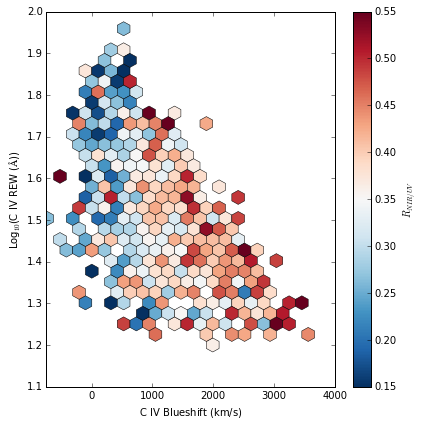

In [314]:
t = Table.read('/home/lc585/qsosed/out.fits')

t_ica = Table.read('/data/vault/phewett/LiamC/liam_civpar_zica_160115.dat', format='ascii') # new ICA
t_ica.rename_column('col1', 'NAME')
t_ica.rename_column('col2', 'CIV_BLUESHIFT_ICA')
t_ica.rename_column('col3', 'CIV_EQW_ICA')

print len(t)
t = join(t, t_ica, join_type='inner', keys='NAME') 
print len(t)

t = t[np.log10(t['CIV_EQW_ICA']) > 1.2]


xdat = t['CIV_BLUESHIFT_ICA']
ydat = np.log10(t['CIV_EQW_ICA'])
C = t['IR_UV_RATIO']

    
fig, ax = plt.subplots(figsize=(6,6))

im = ax.hexbin(xdat,
               ydat,
               C=C,
               gridsize=(25,18),
               mincnt=1,
               reduce_C_function=np.median,
               cmap='RdBu_r',
               edgecolor='black',
               linewidth=0.5,
               vmax=0.55,
               vmin=0.15)

cb = fig.colorbar(im,ax=ax)
cb.set_label(r'$R_{NIR/UV}$')

ax.set_xlabel(r'C$\,$IV Blueshift (km/s)')
ax.set_ylabel(r'Log$_{10}$(C$\,$IV REW ($\AA$))')

ax.set_xlim(-750,4000)
ax.set_ylim(1.1 ,2)

fig.tight_layout()

In [354]:
t = Table.read('/home/lc585/qsosed/out_bbt_fixed.fits')
t = t[['NAME', 'BBT', 'IR_UV_RATIO']]
t.rename_column('NAME', 'SDSS_NAME')

df_fit = t.to_pandas() 

df_bhm = pd.read_csv('/data/lc585/SDSS/civ_bs_basesub.liam', delimiter='|')
df_bhm.drop('Unnamed: 0', inplace=True, axis=1)
df_bhm.drop('Unnamed: 18', inplace=True, axis=1)

df = pd.merge(df_fit, df_bhm, how='inner', on='SDSS_NAME')

                     CIV_LOGBH_CORR_HW10  IR_UV_RATIO
CIV_LOGBH_CORR_HW10              1.00000      0.08902
IR_UV_RATIO                      0.08902      1.00000


(8, 11)

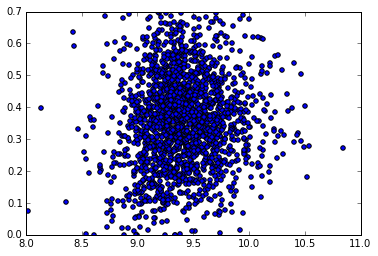

In [356]:
fig, ax = plt.subplots()

df = df[(df.CIV_LOGBH_CORR_HW10 > 8) & (df.CIV_LOGBH_CORR_HW10 < 11) & (df.IR_UV_RATIO < 0.7) & (df.IR_UV_RATIO > 0)]

print df[['CIV_LOGBH_CORR_HW10', 'IR_UV_RATIO']].corr(method='spearman')
ax.scatter(df.CIV_LOGBH_CORR_HW10, df.IR_UV_RATIO)


ax.set_ylim(0, 0.7)
ax.set_xlim(8, 11)

                CIV_LOGBH_SDSS  IR_UV_RATIO
CIV_LOGBH_SDSS         1.00000      0.24763
IR_UV_RATIO            0.24763      1.00000


(8, 11)

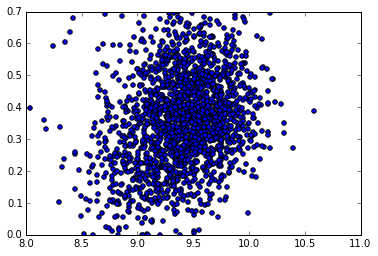

In [357]:
fig, ax = plt.subplots()

df = df[(df.CIV_LOGBH_SDSS > 8) & (df.CIV_LOGBH_SDSS < 11) & (df.IR_UV_RATIO < 0.7) & (df.IR_UV_RATIO > 0)]

print df[['CIV_LOGBH_SDSS', 'IR_UV_RATIO']].corr(method='spearman')
ax.scatter(df.CIV_LOGBH_SDSS, df.IR_UV_RATIO)


ax.set_ylim(0, 0.7)
ax.set_xlim(8, 11)

               LOGL1350_SDSS  IR_UV_RATIO
LOGL1350_SDSS       1.000000    -0.084033
IR_UV_RATIO        -0.084033     1.000000


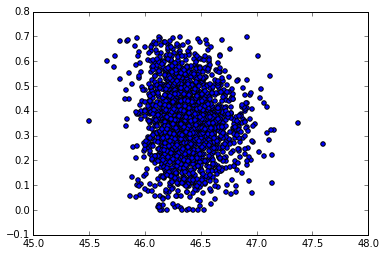

In [358]:
fig, ax = plt.subplots()
ax.scatter(df.LOGL1350_SDSS, df.IR_UV_RATIO)
print df[['LOGL1350_SDSS', 'IR_UV_RATIO']].corr()

             EddRatio  IR_UV_RATIO
EddRatio     1.000000    -0.145929
IR_UV_RATIO -0.145929     1.000000


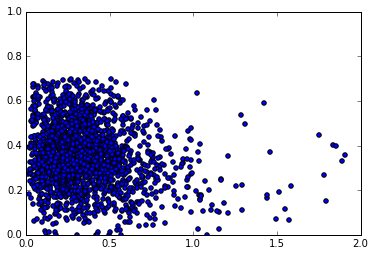

In [359]:
Lbol = 3.81 * 10**df['LOGL1350_SDSS']
Ledd = 3.2e4 * 10**df['CIV_LOGBH_CORR_HW10']
Lbol = Lbol / (3.846e33*(u.erg/u.s)) # in units of solar luminosity
EddRatio = Lbol / Ledd
df['EddRatio'] = EddRatio
fig, ax = plt.subplots()
ax.scatter(df.EddRatio, df.IR_UV_RATIO)
ax.set_xlim(0, 2)
ax.set_ylim(0, 1)
print df[['EddRatio', 'IR_UV_RATIO']].corr(method='spearman')

             EddRatio  IR_UV_RATIO
EddRatio     1.000000    -0.329617
IR_UV_RATIO -0.329617     1.000000


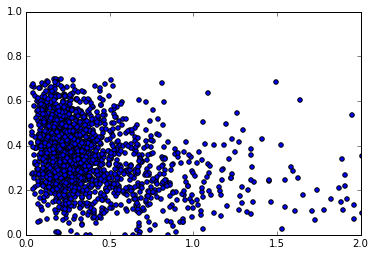

In [360]:
Lbol = 3.81 * 10**df['LOGL1350_SDSS']
Ledd = 3.2e4 * 10**df['CIV_LOGBH_SDSS']
Lbol = Lbol / (3.846e33*(u.erg/u.s)) # in units of solar luminosity
EddRatio = Lbol / Ledd
df['EddRatio'] = EddRatio
fig, ax = plt.subplots()
ax.scatter(df.EddRatio, df.IR_UV_RATIO)
ax.set_xlim(0, 2)
ax.set_ylim(0, 1)
print df[['EddRatio', 'IR_UV_RATIO']].corr(method='spearman')

In [300]:
t['BBFLXNRM_RELERR'] = t['BBFLXNRM_STDERR'] / t['BBFLXNRM']
t = t[t['BBFLXNRM_RELERR'] < np.percentile(t['BBFLXNRM_RELERR'], 90)]

In [185]:
m = ma.masked_invalid(mag)
m = ma.masked_less_equal(m,0.001) # 0.001 in case np.zeros isn't exactly zero

if nrmflg is True:
    m[:,1:] = m[:,1:] - imag.reshape(len(m),1) + 18.0

m[:,10] = m[:,10] + 2.699
m[:,11] = m[:,11] + 3.339
m[:,12] = m[:,12] + 5.174
m[:,13] = m[:,13] + 6.620

sigma = np.zeros((len(dat),13),dtype='float64')

sigma[ind,0] = dat['UMAGERR'][ind]
sigma[ind,1] = dat['GMAGERR'][ind]
sigma[ind,2] = dat['RMAGERR'][ind]
sigma[ind,3] = dat['IMAGERR'][ind]
sigma[ind,4] = dat['ZMAGERR'][ind]
sigma[ind,5] = dat['UKIDSS_YMAG_ERR'][ind]
sigma[ind,6] = dat['UKIDSS_JMAG_ERR'][ind]
sigma[ind,7] = dat['UKIDSS_HMAG_ERR'][ind]
sigma[ind,8] = dat['UKIDSS_KMAG_ERR'][ind]
sigma[ind,9] = dat['W1SIGMPRO_ALLWISE'][ind]
sigma[ind,10] = dat['W2SIGMPRO_ALLWISE'][ind]
sigma[ind,11] = dat['W3SIGMPRO_ALLWISE'][ind]
sigma[ind,12] = dat['W4SIGMPRO_ALLWISE'][ind]

sigma = ma.masked_invalid(sigma)
sigma = ma.masked_less_equal(sigma,0.001) # 0.001 in case np.zeros isn't exactly zero
sigma[ (sigma < 0.1) & ( ~ma.getmask(sigma) ) ] = 0.1 # minimum magnitude error 0.1 for fitting
#print 'WARNING MINIMUM ERROR NOT 0.1!'

snr = np.zeros((len(dat),13),dtype='float64')

snr[ind,0] = 1.0 / (0.4 * np.log(10) * dat['UMAGERR'][ind])
snr[ind,1] = 1.0 / (0.4 * np.log(10) * dat['GMAGERR'][ind])
snr[ind,2] = 1.0 / (0.4 * np.log(10) * dat['RMAGERR'][ind])
snr[ind,3] = 1.0 / (0.4 * np.log(10) * dat['IMAGERR'][ind])
snr[ind,4] =  1.0 / (0.4 * np.log(10) * dat['ZMAGERR'][ind])
snr[ind,5] = dat['UKIDSS_YSNR'][ind]
snr[ind,6] = dat['UKIDSS_JSNR'][ind]
snr[ind,7] = dat['UKIDSS_HSNR'][ind]
snr[ind,8] = dat['UKIDSS_KSNR'][ind]
snr[ind,9] = dat['W1SNR_ALLWISE'][ind]
snr[ind,10] = dat['W2SNR_ALLWISE'][ind]
snr[ind,11] = dat['W3SNR_ALLWISE'][ind]
snr[ind,12] = dat['W4SNR_ALLWISE'][ind]

snr = ma.masked_invalid(snr)
snr = ma.masked_less_equal(snr,snrmin)

# missing data? 

16456    0.000
5583     0.022
14117    0.022
1842     0.022
19115    0.022
7322     0.022
12475    0.022
7589     0.022
7949     0.022
2881     0.022
18075    0.022
13717    0.022
14083    0.022
8416     0.022
5633     0.022
15778    0.022
17988    0.022
14258    0.022
12762    0.022
15758    0.022
2559     0.022
6357     0.022
12398    0.022
2662     0.022
18431    0.022
9705     0.022
9422     0.022
19678    0.022
185      0.022
9392     0.022
         ...  
16372    0.172
17179    0.174
6800     0.177
16436    0.202
16485    0.206
16451    0.207
16409    0.215
17200    0.216
16180    0.218
16356    0.223
16187    0.247
16441    0.252
16199    0.273
17182    0.275
16444    0.281
16416    0.295
16502    0.296
16335    0.300
16361    0.303
17170    0.305
16455    0.307
16197    0.319
16445    0.322
17221    0.332
17187    0.338
16466    0.342
16181    0.347
17176    0.387
15868    0.413
11535    0.475
Name: W1err, dtype: float64


(-1.5, 1.5)

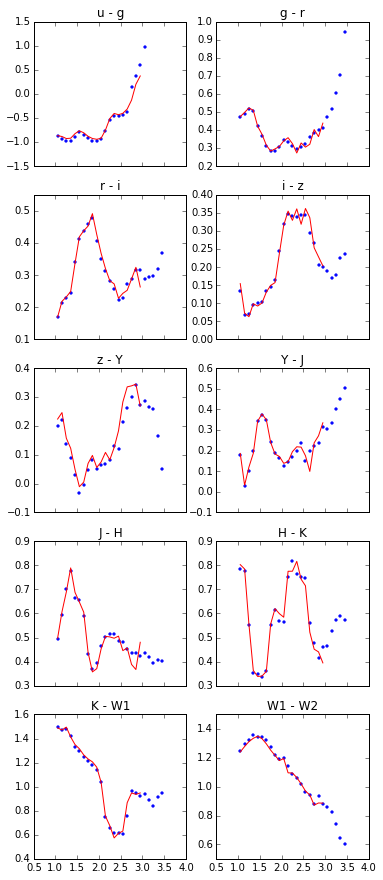

In [179]:
# Add Paul offset, subtract Manda offset 

from qsosed.get_data import get_data
df = get_data() 

colstr1 = ['uVEGA',
           'gVEGA',
           'rVEGA',
           'iVEGA',
           'zVEGA',
           'YVEGA',
           'JVEGA',
           'HVEGA',
           'KVEGA',
           'W1VEGA']

colstr2 = ['gVEGA',
           'rVEGA',
           'iVEGA',
           'zVEGA',
           'YVEGA',
           'JVEGA',
           'HVEGA',
           'KVEGA',
           'W1VEGA',
           'W2VEGA']

# datz = np.arange(1.05, 3, 0.1) 
# numzbin = len(datz)
# datmin = np.min(datz) - 0.05
# datmax = np.max(datz) + 0.05
# binz = np.linspace(datmin, datmax, numzbin+1)

# groups = df.groupby(np.digitize(df.z_HW, binz))

# datarr2 = np.zeros((numzbin, 11))
# datarr2[:, 0] = groups.median().uVEGA[1:-1]
# datarr2[:, 1] = groups.median().gVEGA[1:-1]
# datarr2[:, 2] = groups.median().rVEGA[1:-1]
# datarr2[:, 3] = groups.median().iVEGA[1:-1]
# datarr2[:, 4] = groups.median().zVEGA[1:-1]
# datarr2[:, 5] = groups.median().YVEGA[1:-1]
# datarr2[:, 6] = groups.median().JVEGA[1:-1]
# datarr2[:, 7] = groups.median().HVEGA[1:-1]
# datarr2[:, 8] = groups.median().KVEGA[1:-1]
# datarr2[:, 9] = groups.median().W1VEGA[1:-1]
# datarr2[:, 10] = groups.median().W2VEGA[1:-1]

imag = datarr2[:, 3]
imag = imag[:, np.newaxis]

datarr2 = datarr2 - imag + 18.0

cols = np.zeros((numzbin, 10)) 
cols[:, 0] = datarr2[:, 0] - datarr2[:, 1]
cols[:, 1] = datarr2[:, 1] - datarr2[:, 2]
cols[:, 2] = datarr2[:, 2] - datarr2[:, 3]
cols[:, 3] = datarr2[:, 3] - datarr2[:, 4]
cols[:, 4] = datarr2[:, 4] - datarr2[:, 5]
cols[:, 5] = datarr2[:, 5] - datarr2[:, 6]
cols[:, 6] = datarr2[:, 6] - datarr2[:, 7]
cols[:, 7] = datarr2[:, 7] - datarr2[:, 8]
cols[:, 8] = datarr2[:, 8] - datarr2[:, 9]
cols[:, 9] = datarr2[:, 9] - datarr2[:, 10]

labels = ['u - g', 'g - r', 'r - i', 'i - z', 'z - Y', 'Y - J', 'J - H', 'H - K', 'K - W1', 'W1 - W2']
fig, axs = plt.subplots(5, 2, figsize=(6,15), sharex=True) 

for i, ax in enumerate(axs.flatten()):

    #data definition
    ydat = datarr[:, col1[i]] - datarr[:, col2[i]]

    ax.scatter(datz_paul, 
               ydat, 
               color='blue', 
               s=5)
    
#     ax.scatter(df.z_HW, df[colstr1[i]] - df[colstr2[i]], s=1, alpha=0.1)
    
    ax.plot(datz, 
            cols[:, i], color='red', zorder=5)

    ax.set_title(labels[i])


axs[0, 0].set_ylim(-1.5, 1.5)

In [180]:
len(df)

19837

In [115]:
fname = '/home/lc585/qsosed/sdss_ukidss_wise_medmag_ext.dat'
datarr = np.genfromtxt(fname, usecols=(1,3,5,7,9,11,13,15,17,19,21)) 
datarr[datarr < 0.0] = np.nan 

with open('/home/lc585/qsosed/sdss_ukidss_wise_medmag_ext.dat') as f:
    datz = np.loadtxt(f, usecols=(0,))
        
lameff = np.array([3546.0,
                   4670.0,
                   6156.0,
                   7471.0,
                   8918.0,
                   10305.0,
                   12483.0,
                   16313.0,
                   22010.0,
                   33680.0,
                   46180.0])

lameff = lameff[np.newaxis, :] / (1.0 + datz[:, np.newaxis]) 

mask = lameff < 1500.0

datarr[mask] = np.nan

print datarr

[[ 17.76   18.643  18.17   18.     17.865  17.666  17.485  16.992  16.209
   14.714  13.47 ]
 [ 17.761  18.702  18.214  18.     17.934  17.712  17.684  17.09   16.315
   14.848  13.555]
 [ 17.761  18.743  18.228  18.     17.931  17.794  17.694  16.993  16.441
   14.964  13.642]
 [ 17.777  18.75   18.245  18.     17.904  17.814  17.617  16.839  16.485
   15.064  13.704]
 [    nan  18.761  18.341  18.     17.899  17.87   17.524  16.859  16.509
   15.177  13.834]
 [    nan  18.782  18.414  18.     17.898  17.929  17.555  16.901  16.567
   15.269  13.928]
 [    nan  18.751  18.439  18.     17.867  17.872  17.525  16.935  16.576
   15.332  14.006]
 [    nan  18.742  18.458  18.     17.856  17.808  17.566  17.135  16.584
   15.374  14.096]
 [    nan  18.764  18.478  18.     17.835  17.754  17.568  17.198  16.584
   15.407  14.191]
 [    nan  18.713  18.406  18.     17.755  17.703  17.54   17.144  16.576
   15.439  14.245]
 [    nan  18.691  18.349  18.     17.68   17.617  17.492  17.028  16.

(0, 5000)

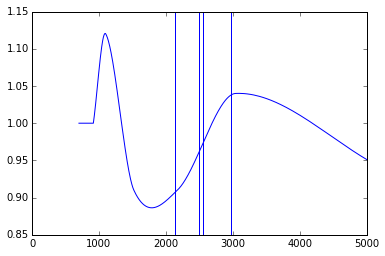

In [126]:
import os
mydir = '/home/lc585/qsosed'
flxcorr = np.genfromtxt(os.path.join(mydir, 'flxcorr.dat'))
f = interp1d(flxcorr[:, 0], flxcorr[:, 1], bounds_error=False, fill_value=1.0)

plt.plot(flxcorr[:, 0], flxcorr[:, 1])

plt.axvline(7471/3)
plt.axvline(8918/3)

plt.axvline(7471/3.5)
plt.axvline(8918/3.5)

plt.xlim(0, 5000)

In [120]:
-2.5*np.log10(1.05)

-0.052973247674845229

* SDSS: asinh magnitudes
* UKIDSS: Vega magnitudes
* WISE: Vega magnitudes 

Manda has cross-matched SDSS, UKIDSS and WISE. 36,607 objects. 

> /data/mbanerji/Projects/Quasar_SED_Paul/SDSSDR7_ULASDR10_AllWISE_ABmags_HWredshift

All magnitudes given in AB system. Vega to AB offsets used by Manda ($m_{AB} = m_{vega} + \Delta m$) are from Hewett et al. (2006) and the WISE supplement:

* u  0.927
* g -0.103
* r  0.146
* i  0.366
* z  0.533
* Y  0.634
* J  0.938
* H  1.379
* K  1.900
* W1 2.699
* W2 3.339

Paul has calculated new Vega to AB offsets:

* u  0.913
* g -0.081
* r  0.169
* i  0.383
* z  0.542
* Y  0.641
* J  0.941
* H  1.378
* K  1.897
* W1 2.691
* W2 3.331

So I can modify the AB magnitudes given in Manda's table by adding $\Delta m_{paul} - \Delta m_{manda}$. 

(Given in http://classic.sdss.org/dr7/algorithms/fluxcal.html).

We find for the A0V star Vega the following:
 
* u-g = +1.02 => uSDSS =  1.02 - 0.08 = 0.94 
*                gSDSS =                -0.08
* g-r = -0.25 => rSDSS = -0.08 + 0.25 = 0.17 
* r-i = -0.23 => iSDSS =  0.17 + 0.23 = 0.40 
* i-z = -0.17 => zSDSS =  0.40 + 0.17 = 0.57 

The SDSS photometry is intended to be on the AB system (Oke & Gunn 1983), by which a magnitude 0 object should have the same counts as a source of Fnu = 3631 Jy. However, this is known not to be exactly true, such that the photometric zeropoints are slightly off the AB standard. To convert from SDSS ugriz to AB ugriz: 

* uAB = uSDSS - 0.04 mag
* gAB = gSDSS 
* rAB = rSDSS
* iAB = iSDSS
* zAB = zSDSS + 0.02 mag 

so in AB system Vega has magnitudes:   

* uAB = 0.94 - 0.04 = 0.90 
* gAB = -0.08 
* rAB = 0.17
* iAB = 0.40
* zAB = 0.57 + 0.02 = 0.59 

Vega has a magnitude V=+0.03 in the Vega system. So to go from AB to Vega:

* uVega = uAB - 0.90 + 0.03 = uAB - 0.87    
* gVega = gAB + 0.08 + 0.03 = gAB + 0.11
* rVega = rAB - 0.17 + 0.03 = rAB - 0.14
* iVega = iAB - 0.40 + 0.03 = iAB - 0.37
* zVega = zAB - 0.59 + 0.03 = zAB - 0.56   

**These are different to Paul's conversions. Why?** 

**What's the difference between Paul's and Manda's Vega->AB for UKIDSS/WISE conversions?** 


## Extinction Correction 

The relative extinction between B and V bands E(B-V) at the position of each object are computed following Schlegel, Finkbeiner, & Davis (1998). Conversions from the selective extinction E(B-V) to the total extinction A in each band-pass were calculated by Paul, assuming a z=1.5 quasar spectral energy distribution and (I think) equation B2 in Schlegel+. These are:

* u  4.875 4.771
* g  3.793 3.821
* r  2.721 2.709
* i  2.099 2.123
* z  1.537 1.688
* Y  1.194 1.282
* J  0.880 0.878
* H  0.569 0.511
* K  0.352 0.281
* W1 0.182 0.120
* W2 0.130 0.064

**Which of these values is used?** 

SDSS quasar catalogue gives the extinction in the u band, which is calculated from the Schlegel maps assuming a z=0 elliptical galaxy SED. Using Table 22 in Stoughton et al. can calculate E(B-V):

E(B-V) = A(u) / 5.155 

and then using this E(B-V): 

* A(u) = 4.875 * E(B-V)
* A(g) = 3.793 * E(B-V)
* ...
* A(W2) = 0.130 * E(B-V)

**Is this how the extinction was calculated?** 

## Magnitude limit 

i<=18.717

This is 19.1 in Vega.  

This extinction curve is usually parameterized in terms of the V-band extinction A(V) and a measure of the relative extinction between B and V band:

$R = A(V) / A(V) - A(B) = A(V) / E(B-V)$

We have galactic extinction curve, which gives the colour excess $E(B-\lambda)$ relative to the colour excess $E(B-V)$ as a function of wavelength $\lambda$.

$E(B-V) = \frac{A(U)}{E(U-V)/E(B-V) + R}$

then 

$A_\lambda = E(B-V) (\frac{E(\lambda - V)}{E(B-V)} + R)$

(ebv * ( ext(3546.0) + 3.1 ))

To calibrate our maps, we assume a standard reddening law, and use the colors of elliptical galaxies to measure the reddening per flux density of 100 micron emission.

A(U) is given assuming a z=0 elliptical galaxy. What would A(U) be instead if a z=1.5 quasar is used? Paul has calculated this. Is this given as a correction to the A(U) in the SDSS table? Ask Paul. 

Conversions from E(B-V) to total extinction $A_\lambda$, assuming a z = 0 elliptical galaxy spectral energy distribution, are

Band A_filter / E(B-V)

u 5.155
g 3.793
r 2.751
i 2.086
z 1.479




Using this can apply extinction correction to ugrizYJHKW1W2 magnitudes. 


(See http://classic.sdss.org/dr7/algorithms/fluxcal.html) 





Unfortunately, R also depends upon the measurement
process. This is because a detector sees a spectral energy dis-
tribution (SED) weighted by a system response function, the
latter determined primarily by the transmission curve of the
filter. This affects not only A, but also E(B-V). Typically, a
filter used to study a galaxy (such as B or V ) is very broad, so
the flux-weighted wavelength of detected photons, referred to
as the effective wavelength, can vary with the shape of the SED;
it depends upon how the light of the source is distributed across
the bandpass. Therefore, at a given reddening, the extinction
affecting a measured magnitude, even after transformations
take out color terms, depends upon the SED. Even if dust were
the same everywhere, RÃ would vary from source to source.

In [6]:
# Main DR7Q
dr7dat = Table.read('/data/sdss/DR7/dr7qso.fit')

with open('/home/lc585/Dropbox/IoA/QSOSED/Model/extcur/gal3ext.sph') as f:
    exttmp = Table.read(f,format='ascii')
    
ext = interp1d(exttmp['col1'], exttmp['col2'])

print dr7dat[200]['AU'] / (ext(3546.0) + 3.1)
print dr7dat[200]['AU'] / 5.155
print dr7dat[]

0.030810956621
0.0292919495635
